In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math

#pandas
from pandas.plotting import parallel_coordinates
from datetime import date, datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

from pyod.models.abod import ABOD
from pyod.models.knn import KNN

<h1>Dataset</h1>

In [2]:
df = pd.read_csv('group_20_fma_numeric.csv', index_col=0)

In [3]:
df

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.534301,0.311606,0.336365,0.341694,0.292243,0.276052,0.341598,0.430064,0.381936,0.529627,...,0,0,256000,168,1293,1,3,9,4,0
3,0.331490,0.296091,0.368770,0.550413,0.464814,0.363497,0.391794,0.581584,0.510926,0.540496,...,0,0,256000,237,514,1,3,9,4,0
5,0.438305,0.298619,0.358552,0.411062,0.515737,0.338845,0.335509,0.353870,0.418968,0.467409,...,0,0,256000,206,1151,1,3,9,4,0
10,0.414595,0.309863,0.438154,0.616182,0.399730,0.369890,0.357122,0.420764,0.370725,0.388618,...,0,0,192000,161,50135,1,3,74,4,0
20,0.354114,0.256808,0.361826,0.415287,0.368049,0.419011,0.390003,0.575782,0.556986,0.491322,...,0,0,256000,311,361,1,3,10,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0.239374,0.506758,0.610919,0.257752,0.253840,0.242582,0.512779,0.418091,0.422479,0.476460,...,0,0,320000,162,102,10,1,0,0,1
155317,0.376784,0.453340,0.290186,0.281965,0.324159,0.404858,0.579709,0.609059,0.567302,0.643192,...,0,0,320000,217,165,10,1,0,0,1
155318,0.297417,0.480687,0.499205,0.311303,0.363107,0.317513,0.582218,0.529418,0.496228,0.579227,...,0,0,320000,404,168,10,1,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 56 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   chroma_cens_02                       103708 non-null  float64
 1   chroma_cens_04                       103708 non-null  float64
 2   chroma_cens_06                       103708 non-null  float64
 3   chroma_cens_07                       103708 non-null  float64
 4   chroma_cens_09                       103708 non-null  float64
 5   chroma_cens_11                       103708 non-null  float64
 6   chroma_stft_05                       103708 non-null  float64
 7   chroma_stft_08                       103708 non-null  float64
 8   chroma_stft_10                       103708 non-null  float64
 9   chroma_stft_12                       103708 non-null  float64
 10  mfcc_02                              103708 non-null  float64
 11  mfcc_03      

In [5]:
class_name = 'album_type'

attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

<h1>Datasets for model approaches</h1>

In [6]:
X_train_merged = pd.read_csv('X_train_merged.csv', index_col=0)

In [7]:
X_test = pd.read_csv('X_test.csv', index_col=0)

In [8]:
X_train_merged = X_train_merged.values
X_test = X_test.values

<h1>Visual approach</h1>

<h2>Box Plot</h2>

In [9]:
df_numeric = df.copy()

In [10]:
df_numeric.shape

(103708, 56)

**For boxplot visualization we maintain only numeric columns and we delete 'album type' column.**

In [11]:
numeric_columns = []  # continous variables
for column_name in df_numeric.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 38


In [12]:
for column in df_numeric:
    if column not in numeric_columns:
        df_numeric = df_numeric.drop(column, axis = 1)
        
print("New df_column:", df_numeric.shape)

New df_column: (103708, 38)


In [13]:
del df_numeric['album_type']

In [14]:
df_numeric.shape[1]

37

In [15]:
n_rows = round(df_numeric.shape[1]/6)
n_rows+=1
n_rows

7

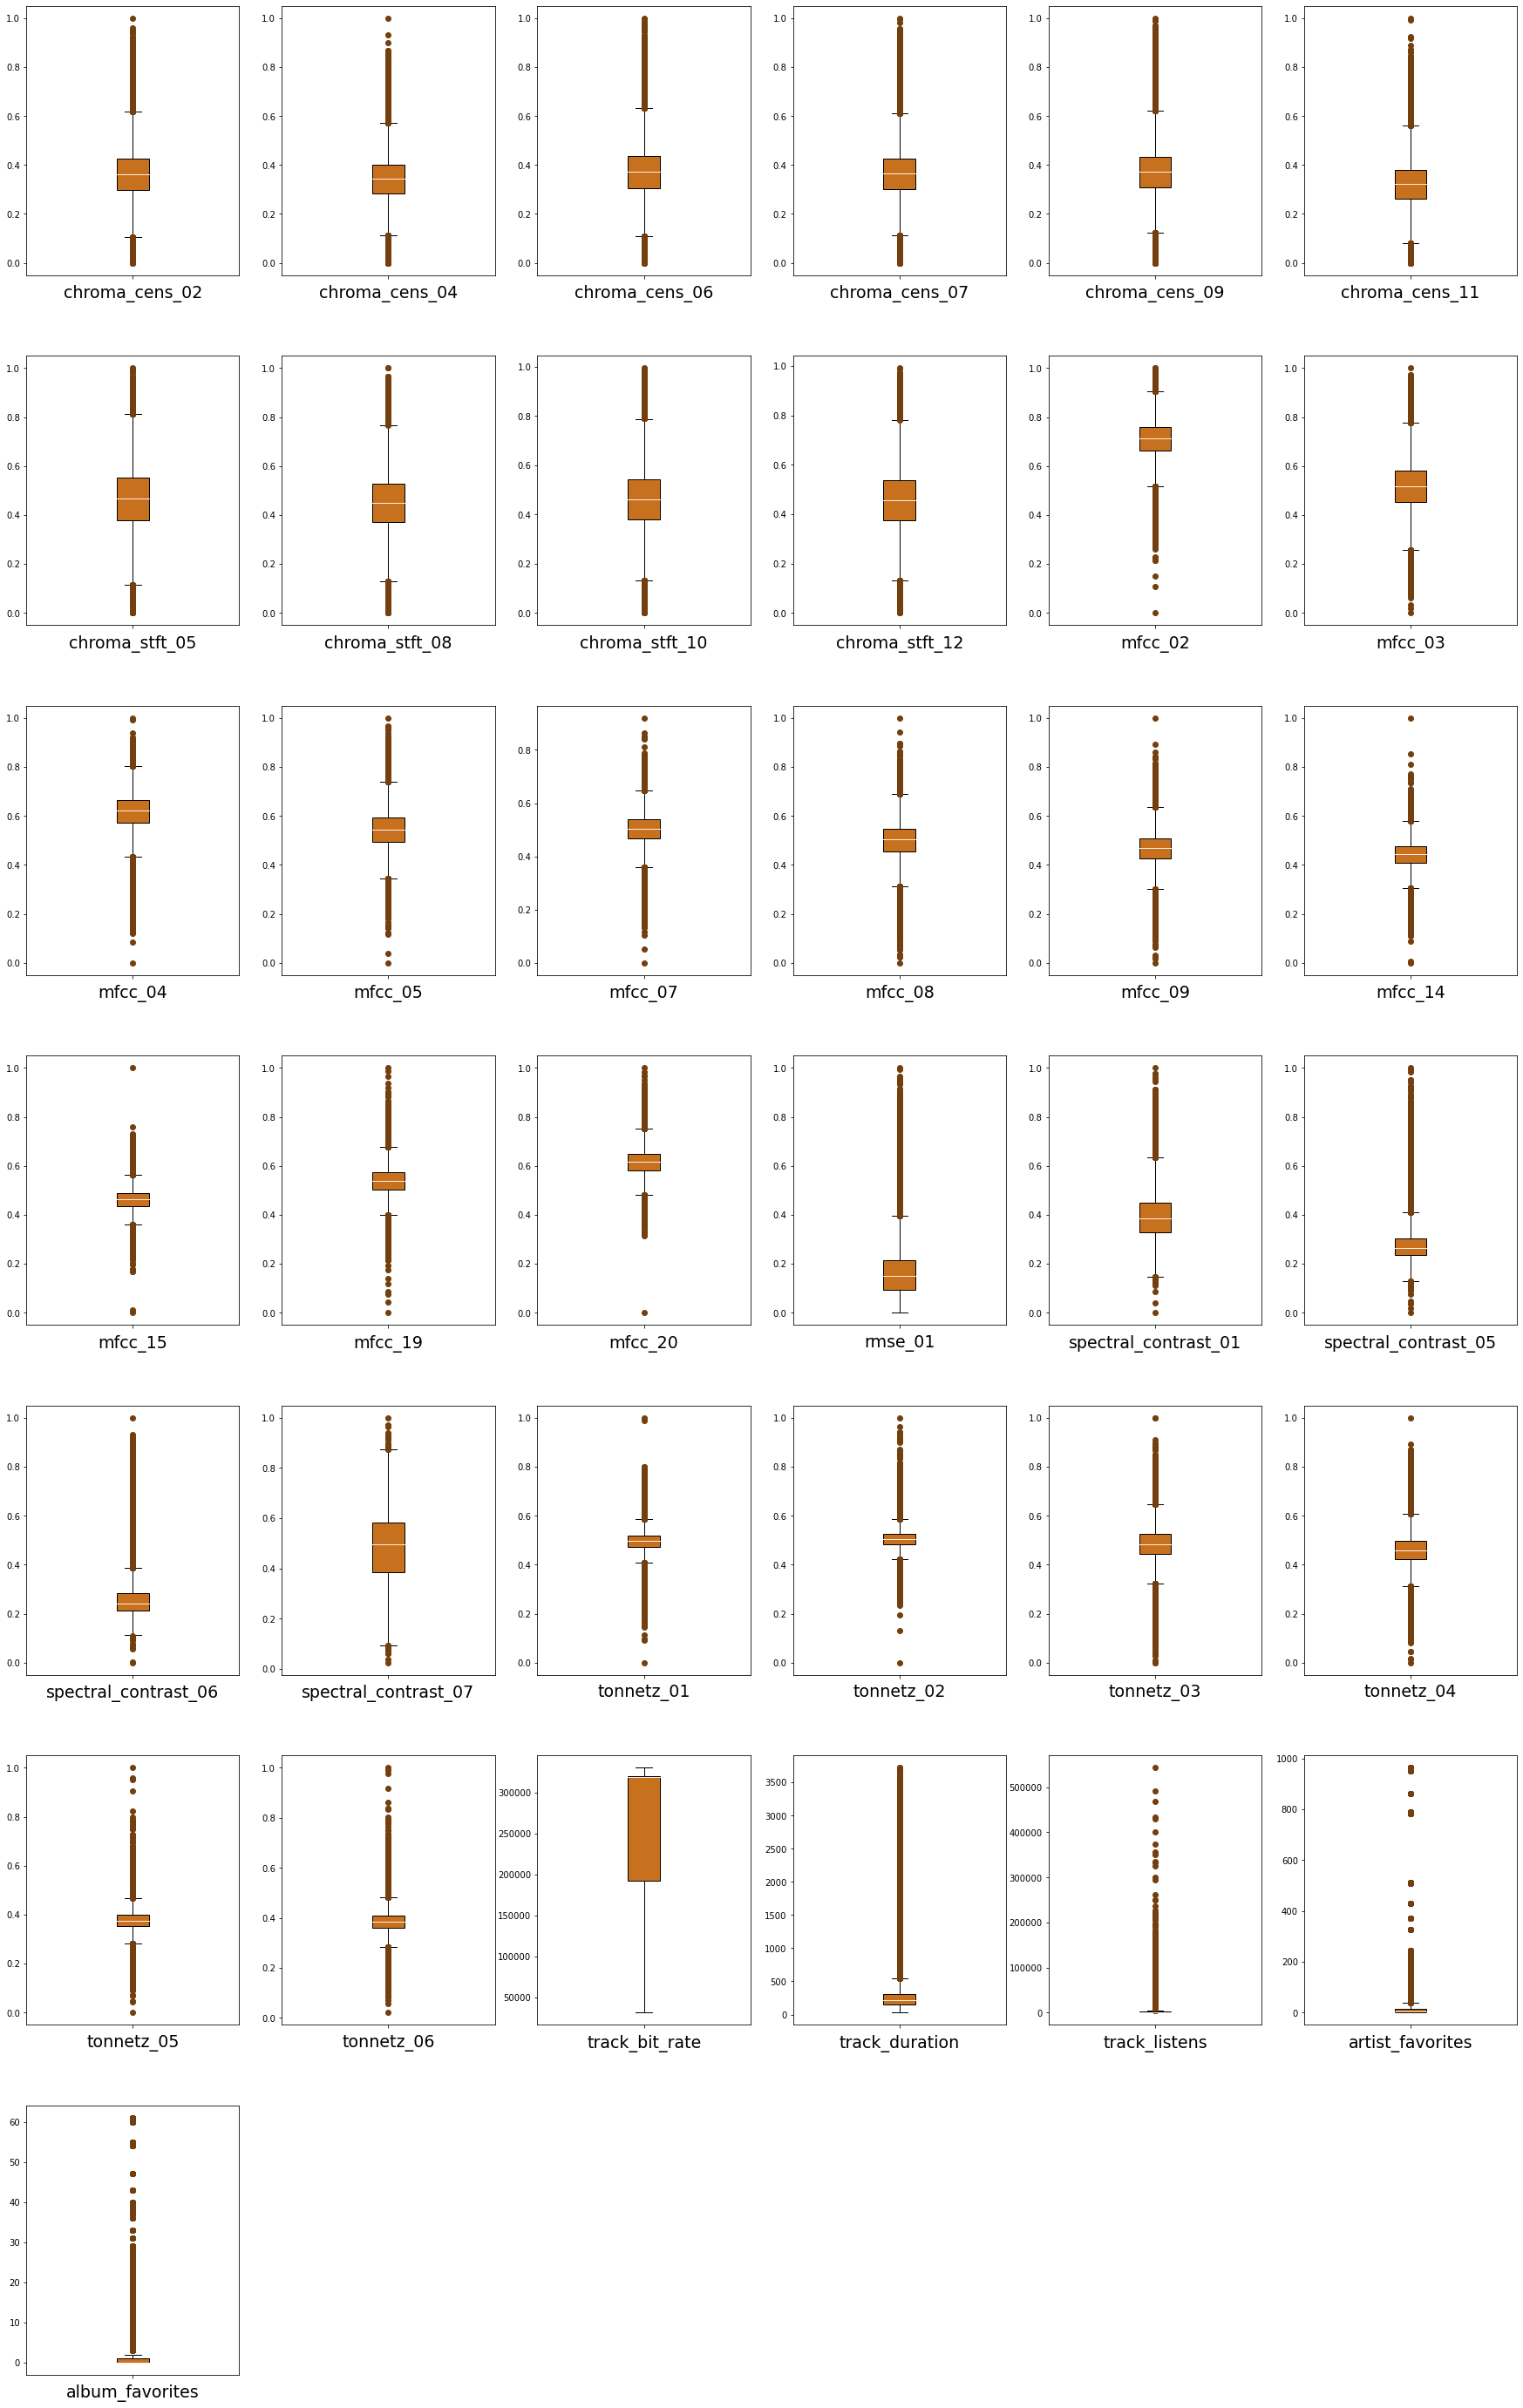

In [16]:
n = -6

fig, ax = plt.subplots(7, 6, figsize = (10, 50))

circles = dict(markerfacecolor='#743f0e', markeredgecolor = '#743f0e', marker='o')

for i in range(n_rows):                         #i = row
    
    n+=6                                        #n = number of column (start of the range for every row)
    
    if i == 6:
        plus = n+1
    else:
        plus = n+6                              #plus = number of column (end of the range for every row)
    
    for p, j in enumerate(range(n, plus)):      #p = progressive num for the boxplots [0-5]; j = num of column
        idx = df_numeric.columns[j]            #name of feature
        col = np.array(df_numeric[idx])        #transform the column in a numpy array
        ax[i, p].boxplot(col, patch_artist=True, medianprops = {'color': '#feeae2'}, flierprops = circles, boxprops= {'facecolor': '#c7711f'}, labels = [''])
        ax[i, p].set_xlabel(idx, fontsize = 19)
    
    fig.subplots_adjust(hspace=0.30, right=2.5)
    
    if i == 6:
        for s in range(1, 6):
            fig.delaxes(ax[i, s])
    
plt.show()

<h1>Proximity based approach</h1>

<h2>Density based (LOF - DBSCAN)</h2>

<h2>LOF</h2>

In [17]:
clf_LOF = LocalOutlierFactor()
y_pred = clf_LOF.fit_predict(X)

In [19]:
clf_LOF.negative_outlier_factor_

array([-0.99025998, -1.03406834, -1.01797733, ..., -0.98680572,
       -0.97641378, -1.10900803])

In [20]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([  3437, 100271]))

**We have 3437 outliers**

In [21]:
np.where(y_pred==-1)

(array([    22,     40,     42, ..., 103635, 103638, 103641]),)

In [22]:
outlier_indexes = np.where(y_pred==-1)[0]

In [23]:
len(outlier_indexes)

3437

In [24]:
outlier_scores = clf_LOF.negative_outlier_factor_[outlier_indexes]

In [25]:
len(outlier_scores)

3437

In [26]:
np.max(outlier_scores)

-1.5000704326652952

In [27]:
np.min(outlier_scores)

-40.363332729962295

In [31]:
np.max(clf_LOF.negative_outlier_factor_[np.where(y_pred==-1)])

-1.5000704326652952

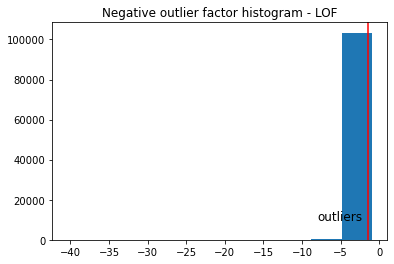

In [71]:
plt.hist(clf_LOF.negative_outlier_factor_, bins=10)
#plt.axvline(-1.5, c='r')
plt.axvline(np.max(clf_LOF.negative_outlier_factor_[np.where(y_pred==-1)]), c='r')
plt.text(-8, 10000, 'outliers', fontsize = 12)
plt.title("Negative outlier factor histogram - LOF")

plt.show()

In [33]:
# filter outlier values
df.iloc[outlier_indexes]

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
track_id,,,,,,,,,,,,,,,,,,,,,
150,0.250197,0.346361,0.531143,0.528220,0.320105,0.297773,0.702071,0.472389,0.462734,0.552111,...,0,0,282817,1182,407,1,3,1,0,0
181,0.393741,0.337096,0.400177,0.419727,0.383776,0.411112,0.310120,0.371475,0.381346,0.462089,...,0,0,256000,171,1339,1,3,76,0,0
183,0.316464,0.326709,0.476155,0.463625,0.391648,0.405148,0.379605,0.472698,0.483240,0.439514,...,0,0,256000,260,869,1,3,76,1,0
184,0.367730,0.316404,0.491146,0.396832,0.295905,0.377951,0.377988,0.403410,0.372882,0.348395,...,0,0,256000,254,831,1,3,76,2,0
185,0.242688,0.348823,0.441420,0.393145,0.413880,0.378066,0.496361,0.509196,0.499556,0.505275,...,0,0,256000,143,1043,1,3,76,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155180,0.245563,0.442371,0.418305,0.294140,0.380539,0.351708,0.604663,0.437013,0.459495,0.446544,...,0,0,128409,208,713,10,1,1,0,0
155225,0.458937,0.393559,0.148841,0.327029,0.305659,0.135463,0.454520,0.390652,0.485630,0.625196,...,0,0,319784,317,50,10,1,0,0,0
155228,0.438778,0.252094,0.300018,0.271448,0.409487,0.371446,0.674070,0.490948,0.546250,0.683078,...,0,0,320172,551,60,10,1,0,0,0


In [34]:
# filter outlier values
X[outlier_indexes]

array([[ 0.25019713,  0.34636086,  0.53114339, ...,  3.        ,
         1.        ,  0.        ],
       [ 0.39374114,  0.33709649,  0.40017687, ...,  3.        ,
        76.        ,  0.        ],
       [ 0.31646396,  0.326709  ,  0.47615542, ...,  3.        ,
        76.        ,  1.        ],
       ...,
       [ 0.43877802,  0.25209415,  0.3000185 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.39896225,  0.28891248,  0.20243888, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.40955119,  0.37226039,  0.42213131, ...,  1.        ,
         0.        ,  0.        ]])

In [104]:
y_outliers = df.iloc[outlier_indexes]

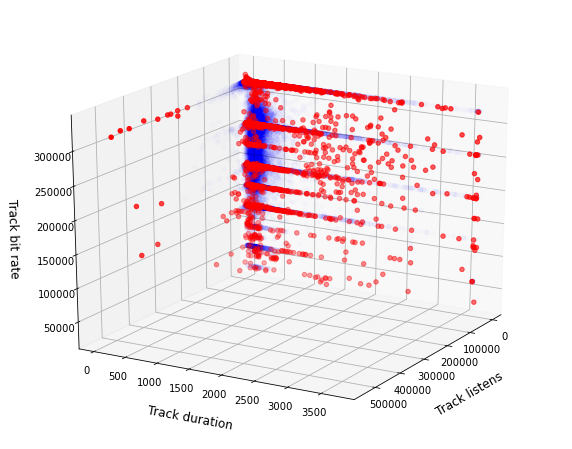

In [172]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

x_vals = df['track_listens']
y_vals = df['track_duration']
z_vals = df['track_bit_rate']

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers['track_listens']
y_vals = y_outliers['track_duration']
z_vals = y_outliers['track_bit_rate']
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('track_listens'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('track_duration'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(20, 30)
plt.show()

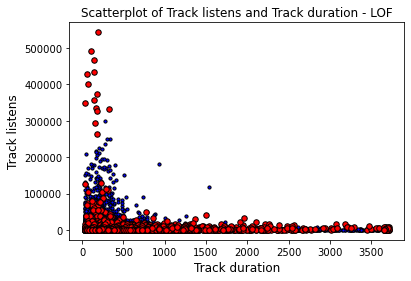

In [105]:
#Scatterplot di Track listens e Track duration
a = plt.scatter(df['track_duration'], df['track_listens'], c='b', edgecolor='k', s=10)
b = plt.scatter(y_outliers['track_duration'], y_outliers['track_listens'], c='red', edgecolor='k', s=30)

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_listens'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track listens and Track duration - LOF")
plt.show()

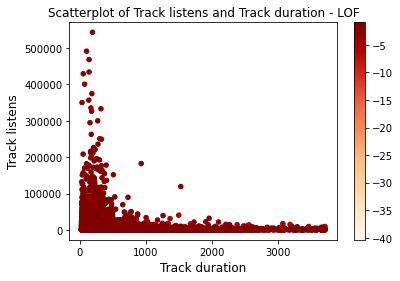

In [106]:
plt.scatter(df['track_duration'], df['track_listens'], s=20, c = clf_LOF.negative_outlier_factor_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_listens'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track listens and Track duration - LOF")

plt.colorbar()
plt.show()

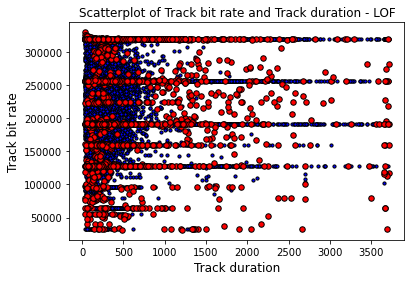

In [107]:
#Scatterplot di Track bit rate e Track duration
a = plt.scatter(df['track_duration'], df['track_bit_rate'], c='b', edgecolor='k', s=10)
b = plt.scatter(y_outliers['track_duration'], y_outliers['track_bit_rate'], c='red', edgecolor='k', s=30)

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - LOF")

plt.show()

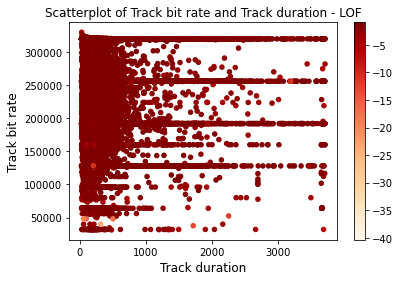

In [108]:
plt.scatter(df['track_duration'], df['track_bit_rate'], s=20, c= clf_LOF.negative_outlier_factor_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - LOF")
plt.colorbar()
plt.show()

**Negative_outlier_factor_**

**The opposite LOF of the training samples**. The higher, the more normal. 
* **Inliers** tend to have a **LOF score close to 1 (negative_outlier_factor_ close to -1)**;
* **Outliers** tend to have a **larger LOF score**.

The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. It is the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors.

<h3>Top 1% outliers</h3>

In [46]:
len(clf_LOF.negative_outlier_factor_)

103708

In [47]:
len(X)

103708

In [48]:
top1perc = int(float(len(X))*0.01)
top1perc

1037

In [49]:
clf_LOF.negative_outlier_factor_

array([-0.99025998, -1.03406834, -1.01797733, ..., -0.98680572,
       -0.97641378, -1.10900803])

I create a list with indexes and scores only for outliers --> **np.where(y_pred==-1)**

In [50]:
outlier_factor_list = []

for i in range(0,len(outlier_scores)):
    outlier_factor_list.append((outlier_indexes[i], outlier_scores[i]))
    
outlier_factor_list

[(22, -1.5000704326652952),
 (40, -1.7291220306837676),
 (42, -1.9927458739901671),
 (43, -1.9219752865504212),
 (44, -1.7470610464735128),
 (84, -1.5332817921336332),
 (87, -1.5491618365793458),
 (91, -1.9388149862487343),
 (92, -1.5747296626459857),
 (94, -1.5654960066840355),
 (96, -1.5690604164012905),
 (253, -1.6292658011610228),
 (479, -1.6397046616523725),
 (494, -1.5108759933246179),
 (501, -1.574584502597571),
 (518, -1.9395864465265),
 (519, -1.8487201590409381),
 (520, -1.596684136669897),
 (603, -1.6074618138993604),
 (647, -2.760374125642074),
 (650, -2.126465593517912),
 (651, -2.9226105590125284),
 (653, -2.961898783538264),
 (726, -9.581801434266477),
 (734, -7.249563213059318),
 (739, -3.4815999180466735),
 (830, -1.607806250865319),
 (1127, -1.5364095727574958),
 (1128, -1.5442010388764975),
 (1132, -1.5255339657475537),
 (1176, -1.5094095225940358),
 (1179, -1.8611563707195244),
 (1180, -1.6459541876124928),
 (1195, -1.9304115285571157),
 (1196, -2.1415785010235764),

In [51]:
def outlier_score(elem):
    return elem[1]

#We sort in ascending order with respect to LOF factor
outlier_factor_list = sorted(outlier_factor_list, key=outlier_score)

In [52]:
len(outlier_factor_list)

3437

In [53]:
outlier_factor_list[:10]

[(17271, -40.363332729962295),
 (50438, -34.525452216970685),
 (70527, -33.637722657508746),
 (70519, -23.439952302025347),
 (101862, -23.33025840006461),
 (70524, -20.483352777561542),
 (73329, -19.285584029461443),
 (50406, -19.113946784417834),
 (101686, -18.978119514556695),
 (26401, -17.51459850596735)]

In [54]:
min([i[1] for i in outlier_factor_list])

-40.363332729962295

In [55]:
max([i[1] for i in outlier_factor_list])

-1.5000704326652952

**Top 1% outliers**

In [56]:
top_outliers_LOF = outlier_factor_list[:top1perc]

In [57]:
top_outliers_LOF

[(17271, -40.363332729962295),
 (50438, -34.525452216970685),
 (70527, -33.637722657508746),
 (70519, -23.439952302025347),
 (101862, -23.33025840006461),
 (70524, -20.483352777561542),
 (73329, -19.285584029461443),
 (50406, -19.113946784417834),
 (101686, -18.978119514556695),
 (26401, -17.51459850596735),
 (101821, -17.09697547038441),
 (45980, -15.282576180680795),
 (14067, -14.401162809988458),
 (24699, -13.810576371527597),
 (42868, -13.333811438555552),
 (33666, -13.19032595766367),
 (60745, -13.10826520905519),
 (49694, -13.089963666137455),
 (85799, -12.806580311192851),
 (103178, -12.401805387315322),
 (67516, -12.198769337903334),
 (12809, -12.089498037926312),
 (97048, -11.949380847513607),
 (30786, -11.915719910721862),
 (86686, -11.823191616625497),
 (29459, -11.509127587909422),
 (24679, -11.364947299901171),
 (81814, -11.28118922079922),
 (60742, -11.115725764215252),
 (19025, -11.070573179227228),
 (33485, -11.019776451462354),
 (70817, -10.977407299541984),
 (103601, 

In [58]:
min([i[1] for i in top_outliers_LOF])

-40.363332729962295

In [59]:
indexes_list = [i[0] for i in top_outliers_LOF] #retrieve indexes of outliers

In [60]:
df_LOF_outliers = df.iloc[indexes_list]

In [61]:
df_LOF_outliers

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
track_id,,,,,,,,,,,,,,,,,,,,,
29059,0.360239,0.282102,0.447102,0.451995,0.414099,0.416045,0.385147,0.456350,0.449789,0.399539,...,0,0,66881,100,59,3,1,7,0,0
75861,0.418933,0.444899,0.475782,0.452506,0.382031,0.277312,0.483526,0.556648,0.458700,0.520863,...,0,0,127154,49,83,6,4,1,0,0
109736,0.397262,0.355346,0.415019,0.421210,0.379745,0.230393,0.468647,0.462325,0.614626,0.299130,...,0,0,127329,135,78,7,3,8,1,0
109728,0.505573,0.312028,0.276049,0.274644,0.456906,0.311242,0.466405,0.386478,0.363591,0.511380,...,0,0,126531,152,79,7,3,2,1,0
152271,0.211507,0.177995,0.288515,0.259633,0.729102,0.450229,0.070315,0.145548,0.093544,0.138545,...,0,0,40000,319,245,10,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104963,0.282743,0.190177,0.495509,0.607144,0.250171,0.287738,0.475105,0.401068,0.429524,0.549743,...,0,0,320299,811,2300,7,1,12,0,0
94320,0.307642,0.376699,0.407433,0.404069,0.507892,0.393517,0.361616,0.524380,0.352537,0.164718,...,0,0,319940,500,383,6,3,0,0,0
113236,0.397171,0.275287,0.359215,0.415297,0.366917,0.282572,0.388468,0.461296,0.394879,0.364615,...,0,0,318611,1280,4292,8,4,0,0,0


In [62]:
#retrieve track id of outliers
outliers_track_id = list(df_LOF_outliers.index)
outliers_track_id[:10]

[29059, 75861, 109736, 109728, 152271, 109733, 113507, 75821, 152064, 41784]

In [63]:
len(outliers_track_id)

1037

<h2>DBSCAN</h2>

In [9]:
scaler = StandardScaler()

In [10]:
scaled_df = scaler.fit_transform(df)

In [11]:
df_dbscan = pd.DataFrame(scaled_df, columns = df.columns)

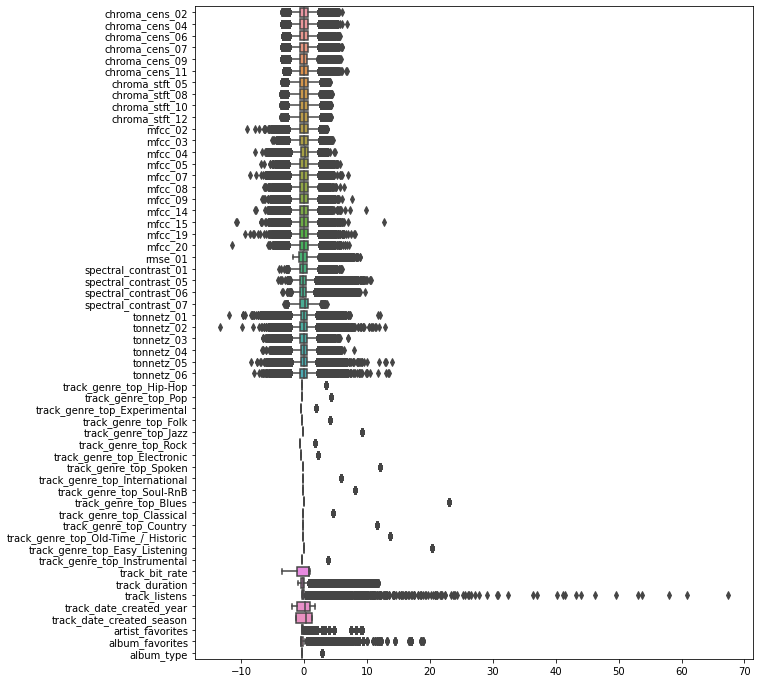

In [12]:
plt.figure(figsize = (10,12))
sns.boxplot(data = df_dbscan, orient = "h")
plt.show()

In [13]:
df_dbscan.describe()

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
count,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,...,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05
mean,3.475115e-16,1.408708e-17,-6.501230e-16,4.152925e-16,2.902340e-16,2.128536e-16,-3.365633e-16,4.432253e-16,-3.233872e-16,1.250569e-16,...,9.758066e-15,-3.851840e-14,-2.366393e-13,-1.546228e-16,5.134238e-16,-4.318462e-13,1.116319e-14,8.170697e-15,-2.519655e-14,-1.105745e-13
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.431825e+00,-3.535373e+00,-3.363941e+00,-3.456964e+00,-3.518991e+00,-3.224404e+00,-3.539405e+00,-3.677637e+00,-3.693617e+00,-3.693157e+00,...,-4.915729e-02,-2.601955e-01,-3.487940e+00,-8.596611e-01,-2.886454e-01,-1.854979e+00,-1.305671e+00,-2.978551e-01,-4.222267e-01,-3.535860e-01
25%,-6.130821e-01,-5.968194e-01,-6.006962e-01,-6.026567e-01,-6.005683e-01,-6.118493e-01,-6.587282e-01,-6.437015e-01,-6.512336e-01,-6.558614e-01,...,-4.915729e-02,-2.601955e-01,-1.070992e+00,-4.368849e-01,-2.525430e-01,-1.058420e+00,-1.305671e+00,-2.879646e-01,-4.222267e-01,-3.535860e-01
50%,5.942583e-04,2.257012e-02,2.314068e-02,9.692222e-03,-9.181907e-03,5.203142e-03,1.555274e-02,2.644788e-02,2.104601e-02,1.419184e-02,...,-4.915729e-02,-2.601955e-01,8.231578e-01,-2.152684e-01,-1.935342e-01,1.364185e-01,4.042919e-01,-2.484023e-01,-4.222267e-01,-3.535860e-01
75%,5.927290e-01,5.934484e-01,5.843749e-01,5.768436e-01,5.668400e-01,5.898878e-01,6.723395e-01,6.664247e-01,6.704365e-01,6.652409e-01,...,-4.915729e-02,-2.601955e-01,8.354293e-01,8.817584e-02,-3.767125e-02,9.329775e-01,1.259274e+00,-1.396059e-01,-1.046833e-01,-3.535860e-01
max,6.024558e+00,6.778853e+00,5.687974e+00,6.033214e+00,5.889364e+00,6.784941e+00,4.093225e+00,4.539411e+00,4.307385e+00,4.339792e+00,...,2.034286e+01,3.843264e+00,9.858014e-01,1.171452e+01,6.734130e+01,1.729537e+00,1.259274e+00,9.226770e+00,1.894792e+01,2.828166e+00


**We create the numpy array for DBSCAN** 

In [14]:
X_dbscan = df.copy()
del X_dbscan['album_type']

In [15]:
X_dbscan

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.534301,0.311606,0.336365,0.341694,0.292243,0.276052,0.341598,0.430064,0.381936,0.529627,...,0,0,0,256000,168,1293,1,3,9,4
3,0.331490,0.296091,0.368770,0.550413,0.464814,0.363497,0.391794,0.581584,0.510926,0.540496,...,0,0,0,256000,237,514,1,3,9,4
5,0.438305,0.298619,0.358552,0.411062,0.515737,0.338845,0.335509,0.353870,0.418968,0.467409,...,0,0,0,256000,206,1151,1,3,9,4
10,0.414595,0.309863,0.438154,0.616182,0.399730,0.369890,0.357122,0.420764,0.370725,0.388618,...,0,0,0,192000,161,50135,1,3,74,4
20,0.354114,0.256808,0.361826,0.415287,0.368049,0.419011,0.390003,0.575782,0.556986,0.491322,...,0,0,0,256000,311,361,1,3,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0.239374,0.506758,0.610919,0.257752,0.253840,0.242582,0.512779,0.418091,0.422479,0.476460,...,0,0,0,320000,162,102,10,1,0,0
155317,0.376784,0.453340,0.290186,0.281965,0.324159,0.404858,0.579709,0.609059,0.567302,0.643192,...,0,0,0,320000,217,165,10,1,0,0
155318,0.297417,0.480687,0.499205,0.311303,0.363107,0.317513,0.582218,0.529418,0.496228,0.579227,...,0,0,0,320000,404,168,10,1,0,0


In [16]:
scaler = StandardScaler()

scaled = scaler.fit_transform(X_dbscan)

In [17]:
scaled_dbscan = pd.DataFrame(scaled, columns = X_dbscan.columns)

In [18]:
scaled_dbscan.describe()

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Old-Time_/_Historic,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites
count,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,...,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05,1.037080e+05
mean,3.475115e-16,1.408708e-17,-6.501230e-16,4.152925e-16,2.902340e-16,2.128536e-16,-3.365633e-16,4.432253e-16,-3.233872e-16,1.250569e-16,...,-2.535958e-14,9.758066e-15,-3.851840e-14,-2.366393e-13,-1.546228e-16,5.134238e-16,-4.318462e-13,1.116319e-14,8.170697e-15,-2.519655e-14
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.431825e+00,-3.535373e+00,-3.363941e+00,-3.456964e+00,-3.518991e+00,-3.224404e+00,-3.539405e+00,-3.677637e+00,-3.693617e+00,-3.693157e+00,...,-7.288440e-02,-4.915729e-02,-2.601955e-01,-3.487940e+00,-8.596611e-01,-2.886454e-01,-1.854979e+00,-1.305671e+00,-2.978551e-01,-4.222267e-01
25%,-6.130821e-01,-5.968194e-01,-6.006962e-01,-6.026567e-01,-6.005683e-01,-6.118493e-01,-6.587282e-01,-6.437015e-01,-6.512336e-01,-6.558614e-01,...,-7.288440e-02,-4.915729e-02,-2.601955e-01,-1.070992e+00,-4.368849e-01,-2.525430e-01,-1.058420e+00,-1.305671e+00,-2.879646e-01,-4.222267e-01
50%,5.942583e-04,2.257012e-02,2.314068e-02,9.692222e-03,-9.181907e-03,5.203142e-03,1.555274e-02,2.644788e-02,2.104601e-02,1.419184e-02,...,-7.288440e-02,-4.915729e-02,-2.601955e-01,8.231578e-01,-2.152684e-01,-1.935342e-01,1.364185e-01,4.042919e-01,-2.484023e-01,-4.222267e-01
75%,5.927290e-01,5.934484e-01,5.843749e-01,5.768436e-01,5.668400e-01,5.898878e-01,6.723395e-01,6.664247e-01,6.704365e-01,6.652409e-01,...,-7.288440e-02,-4.915729e-02,-2.601955e-01,8.354293e-01,8.817584e-02,-3.767125e-02,9.329775e-01,1.259274e+00,-1.396059e-01,-1.046833e-01
max,6.024558e+00,6.778853e+00,5.687974e+00,6.033214e+00,5.889364e+00,6.784941e+00,4.093225e+00,4.539411e+00,4.307385e+00,4.339792e+00,...,1.372036e+01,2.034286e+01,3.843264e+00,9.858014e-01,1.171452e+01,6.734130e+01,1.729537e+00,1.259274e+00,9.226770e+00,1.894792e+01


**We try initially a random inizialization of parameters**

In [19]:
dbscan = DBSCAN(eps=7, min_samples=5).fit(scaled_dbscan)

In [20]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1715, 96869,  1206,   691,  1488,   185,   740,   536,   227,
            8,     8,     6,     6,    23]))

In [21]:
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 13
Estimated number of noise points: 1715


In [27]:
eps_to_test = list(range(1, 10, 1))
min_samples_to_test = list(range(5, 50, 5))

print("eps:", eps_to_test)
print("min_samples:", min_samples_to_test)

eps: [1, 2, 3, 4, 5, 6, 7, 8, 9]
min_samples: [5, 10, 15, 20, 25, 30, 35, 40, 45]


In [30]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan.labels_[dbscan.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [33]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test)

In [35]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scaled_dbscan, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps =   1 and min_samples =   5 | 4.086   31
  2 | Tested with eps =   1 and min_samples =  10 | 4.081    6
  3 | Tested with eps =   1 and min_samples =  15 | 4.079    1
  4 | Tested with eps =   1 and min_samples =  20 | 4.079    1
  5 | Tested with eps =   1 and min_samples =  25 | 4.079    1
  6 | Tested with eps =   1 and min_samples =  30 | 4.079    1
  7 | Tested with eps =   1 and min_samples =  35 | 4.079    1
  8 | Tested with eps =   1 and min_samples =  40 | 4.079    1
  9 | Tested with eps =   1 and min_samples =  45 | 4.077    0
 10 | Tested with eps =   2 and min_samples =   5 | 4.114  179
 11 | Tested with eps =   2 and min_samples =  10 | 4.087   19
 12 | Tested with eps =   2 and min_samples =  15 | 4.084    8
 13 | Tested with eps =   2 and min_samples =  20 | 4.082    4
 14 | Tested with eps =   2 and min_samples =  25

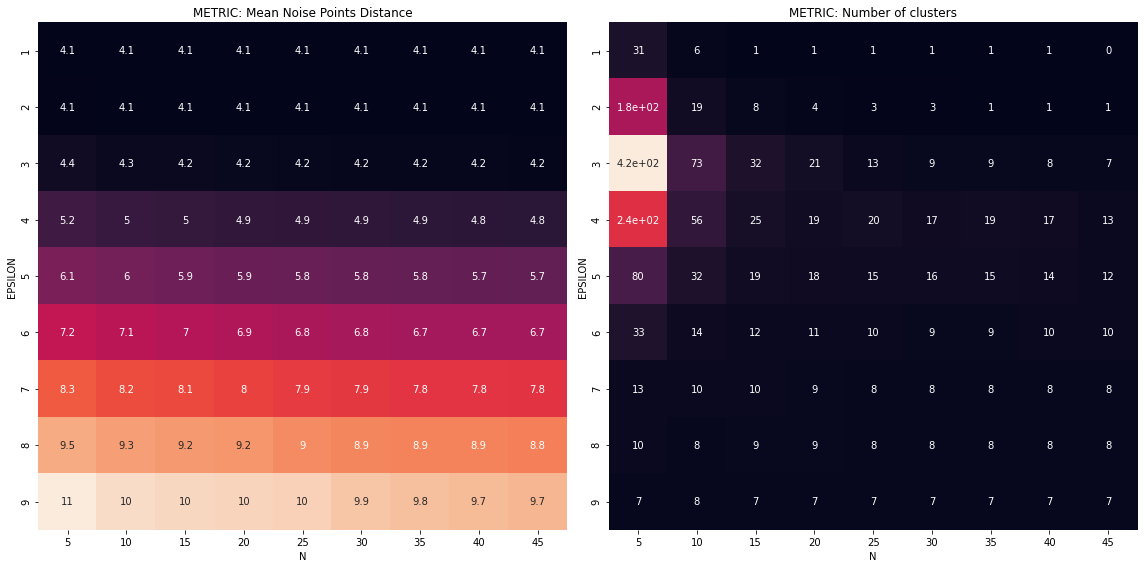

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [38]:
# Istantiating with eps = 9 and min_samples = 5 (best model)
best_dbscan_model = DBSCAN(eps = 9, min_samples = 5)

# Fitting
best_dbscan_model.fit(scaled_dbscan)

# Extracting labels
scaled_dbscan["LABEL"] = best_dbscan_model.labels_

In [39]:
np.unique(best_dbscan_model.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6]),
 array([  281, 99765,  1217,   703,   190,   757,   547,   248]))

In [40]:
scaled_dbscan

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,LABEL
0,1.620733,-0.321399,-0.319193,-0.214224,-0.769461,-0.461302,-0.932118,-0.143779,-0.621960,0.597326,...,-0.049157,-0.260195,-0.122927,-0.389152,-0.127803,-1.854979,0.404292,-0.208840,0.847947,0
1,-0.297128,-0.481421,-0.025863,1.766557,0.854144,0.413959,-0.548983,1.101264,0.415417,0.685370,...,-0.049157,-0.260195,-0.122927,-0.153898,-0.224781,-1.854979,0.404292,-0.208840,0.847947,0
2,0.712953,-0.455354,-0.118361,0.444088,1.333244,0.167214,-0.978589,-0.769871,-0.324137,0.093300,...,-0.049157,-0.260195,-0.122927,-0.259592,-0.145481,-1.854979,0.404292,-0.208840,0.847947,0
3,0.488744,-0.339375,0.602188,2.390711,0.241814,0.477954,-0.813629,-0.220200,-0.712122,-0.544982,...,-0.049157,-0.260195,-1.081283,-0.413019,5.952594,-1.854979,0.404292,0.434048,0.847947,0
4,-0.083183,-0.886595,-0.088720,0.484181,-0.056256,0.969619,-0.562656,1.053590,0.785847,0.287016,...,-0.049157,-0.260195,-0.122927,0.098404,-0.243829,-1.854979,0.404292,-0.198949,0.212860,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103703,-1.168211,1.691439,2.166046,-1.010854,-1.130775,-0.796315,0.374449,-0.242164,-0.295899,0.166619,...,-0.049157,-0.260195,0.835429,-0.409609,-0.276072,1.729537,-1.305671,-0.297855,-0.422227,0
103704,0.131189,1.140482,-0.737198,-0.781062,-0.469184,0.827960,0.885297,1.327027,0.868816,1.517308,...,-0.049157,-0.260195,0.835429,-0.222087,-0.268229,1.729537,-1.305671,-0.297855,-0.422227,0
103705,-0.619333,1.422538,1.154817,-0.502639,-0.102755,-0.046304,0.904452,0.672615,0.297215,0.999125,...,-0.049157,-0.260195,0.835429,0.415486,-0.267855,1.729537,-1.305671,-0.297855,-0.422227,0
103706,0.123813,0.188376,0.976688,0.759591,0.295254,-0.382676,1.260654,0.654616,-0.383762,1.293372,...,-0.049157,-0.260195,0.835429,-0.464161,-0.252170,1.729537,-1.305671,-0.297855,-0.422227,0


In [58]:
dbscan_indexes = list(X_dbscan.index)

In [59]:
scaled_dbscan_with_track_id = scaled_dbscan.copy()

In [61]:
scaled_dbscan_with_track_id['track_id'] = dbscan_indexes

In [89]:
scaled_dbscan_with_track_id = scaled_dbscan_with_track_id.set_index('track_id')

In [110]:
scaled_dbscan_with_track_id

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,LABEL
track_id,,,,,,,,,,,,,,,,,,,,,
2,1.620733,-0.321399,-0.319193,-0.214224,-0.769461,-0.461302,-0.932118,-0.143779,-0.621960,0.597326,...,-0.049157,-0.260195,-0.122927,-0.389152,-0.127803,-1.854979,0.404292,-0.208840,0.847947,0
3,-0.297128,-0.481421,-0.025863,1.766557,0.854144,0.413959,-0.548983,1.101264,0.415417,0.685370,...,-0.049157,-0.260195,-0.122927,-0.153898,-0.224781,-1.854979,0.404292,-0.208840,0.847947,0
5,0.712953,-0.455354,-0.118361,0.444088,1.333244,0.167214,-0.978589,-0.769871,-0.324137,0.093300,...,-0.049157,-0.260195,-0.122927,-0.259592,-0.145481,-1.854979,0.404292,-0.208840,0.847947,0
10,0.488744,-0.339375,0.602188,2.390711,0.241814,0.477954,-0.813629,-0.220200,-0.712122,-0.544982,...,-0.049157,-0.260195,-1.081283,-0.413019,5.952594,-1.854979,0.404292,0.434048,0.847947,0
20,-0.083183,-0.886595,-0.088720,0.484181,-0.056256,0.969619,-0.562656,1.053590,0.785847,0.287016,...,-0.049157,-0.260195,-0.122927,0.098404,-0.243829,-1.854979,0.404292,-0.198949,0.212860,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,-1.168211,1.691439,2.166046,-1.010854,-1.130775,-0.796315,0.374449,-0.242164,-0.295899,0.166619,...,-0.049157,-0.260195,0.835429,-0.409609,-0.276072,1.729537,-1.305671,-0.297855,-0.422227,0
155317,0.131189,1.140482,-0.737198,-0.781062,-0.469184,0.827960,0.885297,1.327027,0.868816,1.517308,...,-0.049157,-0.260195,0.835429,-0.222087,-0.268229,1.729537,-1.305671,-0.297855,-0.422227,0
155318,-0.619333,1.422538,1.154817,-0.502639,-0.102755,-0.046304,0.904452,0.672615,0.297215,0.999125,...,-0.049157,-0.260195,0.835429,0.415486,-0.267855,1.729537,-1.305671,-0.297855,-0.422227,0


In [90]:
scaled_dbscan_with_track_id[scaled_dbscan_with_track_id['LABEL'] == -1]

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,LABEL
track_id,,,,,,,,,,,,,,,,,,,,,
1933,-1.321403,-0.610101,-2.016226,1.494285,2.044961,-0.005710,0.167573,1.704183,0.632864,-2.157722,...,-0.049157,-0.260195,-0.122927,-0.225497,-0.273457,-1.854979,0.404292,-0.297855,-0.422227,-1
3284,-1.298224,-1.064007,-2.237134,2.460129,1.470991,-0.999084,-2.720078,3.769155,-3.259463,-2.381611,...,-0.049157,-0.260195,-0.122927,0.804168,-0.026592,-1.854979,1.259274,-0.189059,-0.422227,-1
3558,-0.629036,0.017678,-2.682381,-0.974354,2.742791,-1.836164,-2.271578,-0.008210,-1.644400,-2.716852,...,-0.049157,-0.260195,-0.122927,0.214327,-0.151332,-1.854979,1.259274,0.147221,0.212860,-1
4853,-0.750679,-1.670893,1.267677,3.468152,-0.071136,-0.083502,-2.244005,-2.524580,2.149165,-1.341799,...,-0.049157,-0.260195,-2.997996,-0.361876,-0.102531,-1.456700,1.259274,0.038424,0.530404,-1
4945,-2.325468,-2.530134,-2.259697,-2.362962,-1.787494,2.837959,-2.206335,-2.028099,-1.506885,3.329188,...,-0.049157,-0.260195,-2.997996,-0.760786,-0.264743,-1.456700,1.259274,0.038424,0.530404,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152067,-1.511132,-1.390015,0.549003,-0.159181,1.917956,0.212816,-0.922071,0.582352,1.336467,0.389479,...,-0.049157,-0.260195,-2.518818,-0.743739,-0.279309,1.729537,1.259274,-0.287965,-0.422227,-1
152273,-1.319924,-2.640001,1.274233,2.626378,1.453014,-1.554742,-2.856169,1.324821,-1.847614,-1.986583,...,-0.049157,-0.260195,-2.997996,-0.539169,-0.267233,1.729537,1.259274,-0.297855,-0.422227,-1
153742,-2.691826,2.759206,2.410535,-3.354522,-2.248599,-1.376792,2.348603,1.338161,0.602647,0.711824,...,-0.049157,3.843264,0.835429,-0.508484,-0.099170,1.729537,1.259274,7.456357,-0.422227,-1


In [92]:
#retrieve track id of outliers
outliers_dbscan = list(scaled_dbscan_with_track_id[scaled_dbscan_with_track_id['LABEL'] == -1].index)
outliers_dbscan[:10]

[1933, 3284, 3558, 4853, 4945, 7022, 7390, 8161, 8162, 9222]

In [93]:
len(outliers_dbscan)

281

In [115]:
# open file
with open('outliers_dbscan(track_id).txt', 'w+') as f:
      
    # write elements of list
    for items in outliers_dbscan:
        f.write('%s\n' %items)
      
    print("File written successfully")
    
# close the file
f.close()

File written successfully


<h2>Distance based (KNN)</h2>

<h2>KNN</h2>

In [64]:
clf_KNN = KNN()
clf_KNN.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

**Decision_scores_**

**The outlier scores of the training data**. The higher, the more abnormal. Outliers tend to have higher scores. This value is available once the detector is fitted.

In [65]:
clf_KNN.decision_scores_

array([14.3779018 , 12.86007477, 14.0423608 , ...,  8.78306132,
        5.92671461, 10.81538555])

In [66]:
anomlay_score = clf_KNN.decision_function(X)

In [67]:
anomlay_score

array([14.29121967, 12.716913  , 13.42829889, ...,  8.56739123,
        5.87710859, 10.55196321])

In [68]:
outliers_KNN = clf_KNN.predict(X)
np.unique(outliers_KNN, return_counts=True)

(array([0, 1]), array([94412,  9296]))

In [72]:
np.where(outliers_KNN == 1)

(array([     3,     21,     22, ..., 103481, 103598, 103601]),)

In [73]:
outlier_indexes_knn = np.where(outliers_KNN==1)[0]

In [74]:
len(outlier_indexes_knn)

9296

In [75]:
outlier_scores_knn = clf_KNN.decision_scores_[outlier_indexes_knn]

In [76]:
len(outlier_scores_knn)

9296

In [77]:
np.min(outlier_scores_knn)

262.6352962343885

In [78]:
np.max(outlier_scores_knn)

194915.793269169

In [79]:
outlier_knn_list = []

for i in range(0,len(outlier_scores_knn)):
    outlier_knn_list.append((outlier_indexes_knn[i], outlier_scores_knn[i]))
    
outlier_knn_list

[(3, 1854.1834501246103),
 (21, 764.7291333636774),
 (22, 660.6248286280414),
 (71, 332.57816129132704),
 (195, 436.81845427120214),
 (324, 300.29234319040535),
 (325, 480.69767205071633),
 (343, 507.5483020365121),
 (346, 640.3337673187109),
 (374, 598.6770616675321),
 (603, 600.282647900133),
 (604, 312.2922305159073),
 (748, 625.5727599933155),
 (826, 305.7617650486032),
 (829, 315.43184920892395),
 (830, 491.5236825427763),
 (904, 360.30710275781337),
 (976, 4095.5624343682753),
 (984, 354.78812432632856),
 (985, 436.45248483944044),
 (986, 331.319004544056),
 (1297, 3777.12729220326),
 (1298, 596.7198445723874),
 (1299, 456.3206017828701),
 (1300, 602.1276020059557),
 (1301, 487.24779484163236),
 (1310, 323.39683437178144),
 (1538, 338.26773599955067),
 (1539, 375.742138067802),
 (1583, 1026.2505875282604),
 (1660, 336.42287955706183),
 (1670, 303.9035370018686),
 (1701, 424.2042487701916),
 (1819, 472.65862652747063),
 (1845, 612.0401018131222),
 (1932, 389.24299519238036),
 (195

In [80]:
outlier_knn_list = sorted(outlier_knn_list, key=outlier_score, reverse = True)

In [82]:
np.min(clf_KNN.decision_scores_[np.where(outliers_KNN==1)])

262.6352962343885

In [83]:
np.max(clf_KNN.decision_scores_[np.where(outliers_KNN==1)])

194915.793269169

In [89]:
outlier_knn_list[:10]

[(14443, 194915.793269169),
 (26842, 168756.9456506676),
 (49651, 143866.9304933536),
 (53166, 135985.0335643966),
 (40658, 129248.35640829257),
 (43466, 127121.69032871793),
 (57355, 127121.69032871793),
 (62388, 94934.9857386406),
 (50011, 81324.77701939798),
 (56020, 79895.08527056912)]

**Top 1% outliers**

In [90]:
top_outliers_knn = outlier_knn_list[:top1perc]

In [91]:
indexes_list_knn = [i[0] for i in top_outliers_knn] #retrieve index of outliers

In [93]:
df_knn_outliers = df.iloc[indexes_list_knn]

In [94]:
df_knn_outliers

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
track_id,,,,,,,,,,,,,,,,,,,,,
24425,0.582551,0.260160,0.302664,0.249650,0.218681,0.332331,0.265682,0.252215,0.359387,0.291845,...,0,0,128000,143,433992,3,4,92,12,0
42377,0.437262,0.388607,0.333384,0.412298,0.459646,0.248444,0.407478,0.482299,0.435781,0.454637,...,0,0,320000,194,543252,4,4,963,40,0
74724,0.297640,0.203927,0.225620,0.275323,0.132179,0.580131,0.338399,0.320418,0.306930,0.620235,...,0,0,128000,36,349903,5,4,26,11,0
81466,0.343412,0.157643,0.290649,0.268104,0.272471,0.300327,0.233884,0.171380,0.322450,0.295008,...,0,1,320000,105,491235,6,1,784,6,0
62460,0.250007,0.277574,0.238124,0.390601,0.471316,0.352164,0.439000,0.380467,0.473875,0.475469,...,0,0,192000,139,356588,5,1,788,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95860,0.323096,0.365143,0.383678,0.386088,0.374436,0.263336,0.557440,0.438682,0.441930,0.420041,...,0,0,140074,58,3296,6,4,13,1,0
134321,0.381284,0.413798,0.363447,0.385816,0.413109,0.322124,0.449545,0.495695,0.434005,0.363473,...,0,0,187212,1609,2864,9,1,9,0,0
107797,0.379861,0.394784,0.419749,0.386731,0.396034,0.338006,0.518699,0.514174,0.530580,0.494348,...,0,0,320000,3706,7120,7,2,1,0,0


In [95]:
#retrieve track id of outliers
outliers_track_id_knn = list(df_knn_outliers.index)
outliers_track_id_knn[:10]

[24425, 42377, 74724, 81466, 62460, 66053, 86599, 95976, 75328, 84990]

In [96]:
len(outliers_track_id_knn)

1037

In [97]:
np.min(clf_KNN.decision_scores_[np.where(outliers_KNN==1)])

262.6352962343885

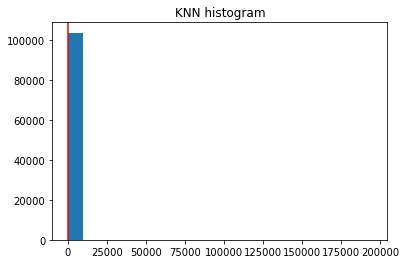

In [98]:
plt.hist(clf_KNN.decision_scores_, bins=20)
plt.axvline(np.min(clf_KNN.decision_scores_[np.where(outliers_KNN==1)]), c='r')

plt.title("KNN histogram")
plt.show()

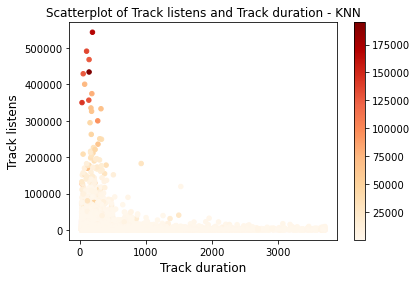

In [109]:
plt.scatter(df['track_duration'], df['track_listens'], s=20, c = clf_KNN.decision_scores_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_listens'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track listens and Track duration - KNN")

plt.colorbar()
plt.show()

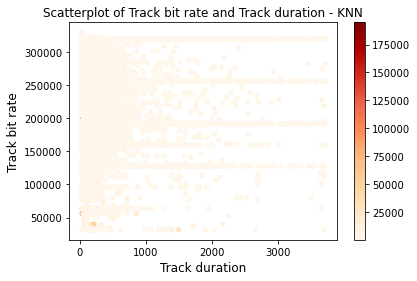

In [110]:
plt.scatter(df['track_duration'], df['track_bit_rate'], s=20, c = clf_KNN.decision_scores_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - KNN")
plt.colorbar()
plt.show()

<h1>Angle based approach</h1>

<h2>ABOD</h2>

In [111]:
clf_ABOD = ABOD()
clf_ABOD.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=5)

**Decision_scores_**

**The outlier scores of the training data**. The higher, the more abnormal. Outliers tend to have higher scores. This value is available once the detector is fitted.

In [112]:
clf_ABOD.decision_scores_

array([-3.94968344e-06, -7.86794794e-06, -7.08261324e-06, ...,
       -3.87035280e-05, -5.96919611e-04, -2.12542969e-05])

In [113]:
min(clf_ABOD.decision_scores_)

-2838.7545185027616

In [114]:
max(clf_ABOD.decision_scores_)

-9.064251649140673e-22

In [115]:
outliers = clf_ABOD.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([93452, 10256]))

In [116]:
np.where(outliers==1)

(array([     3,     21,     22, ..., 103601, 103635, 103638]),)

In [117]:
outlier_indexes_abod = np.where(outliers==1)[0]
outlier_indexes_abod

array([     3,     21,     22, ..., 103601, 103635, 103638])

In [118]:
len(outlier_indexes_abod)

10256

In [119]:
outlier_scores_abod = clf_ABOD.decision_scores_[outlier_indexes_abod]

In [120]:
len(outlier_scores_abod)

10256

In [121]:
np.max(outlier_scores_abod)

-9.064251649140673e-22

In [122]:
np.min(outlier_scores_abod)

-6.595392927479469e-09

In [123]:
outlier_abod_list = []

for i in range(0,len(outlier_scores_abod)):
    outlier_abod_list.append((outlier_indexes_abod[i], outlier_scores_abod[i]))
    
outlier_abod_list

[(3, -5.528503643691476e-12),
 (21, -4.133743166925014e-12),
 (22, -4.028964334528095e-12),
 (71, -1.598632084636069e-10),
 (195, -3.924044831398503e-11),
 (324, -4.7730834105179966e-11),
 (325, -2.0071467378383327e-11),
 (343, -8.64599387839624e-11),
 (346, -1.6594069937417293e-11),
 (374, -2.730665456673304e-12),
 (601, -7.242305545026905e-11),
 (603, -4.644389358695617e-11),
 (604, -7.113826165497034e-11),
 (731, -1.9228522660596386e-10),
 (739, -5.0650317079145503e-11),
 (826, -1.1465320321281155e-10),
 (829, -1.2367732465839163e-10),
 (830, -3.2537512915888873e-11),
 (976, -9.650711407315593e-15),
 (984, -5.227922707076906e-11),
 (985, -7.842686186751709e-11),
 (986, -5.008897876682284e-11),
 (1297, -1.1316878548713942e-14),
 (1298, -5.311084424910189e-12),
 (1299, -2.339359997278999e-11),
 (1300, -1.768358318501147e-11),
 (1301, -7.945494775554654e-11),
 (1310, -8.825405815698887e-12),
 (1430, -1.0388324343448812e-10),
 (1435, -1.8638984699627775e-10),
 (1539, -2.3184778401872352

In [124]:
outlier_abod_list = sorted(outlier_abod_list, key=outlier_score, reverse = True)

In [125]:
np.min(clf_ABOD.decision_scores_[np.where(outliers==1)])

-6.595392927479469e-09

In [128]:
np.max(clf_ABOD.decision_scores_[np.where(outliers==1)])

-9.064251649140673e-22

In [127]:
outlier_abod_list[:10]

[(14443, -9.064251649140673e-22),
 (26842, -4.1977292125287804e-21),
 (57355, -4.9773047650858335e-21),
 (49651, -5.156172615049123e-21),
 (59440, -9.778826364766189e-21),
 (40658, -9.910097788781825e-21),
 (50011, -1.1870124950977123e-20),
 (62388, -1.7268469176109632e-20),
 (36725, -2.915511970839384e-20),
 (57478, -3.339940409902054e-20)]

In [129]:
min([i[1] for i in outlier_abod_list])

-6.595392927479469e-09

In [130]:
max([i[1] for i in outlier_abod_list])

-9.064251649140673e-22

**Top 1% outliers**

In [131]:
top_outliers_ABOD = outlier_abod_list[:top1perc]

In [132]:
indexes_list_ABOD = [i[0] for i in top_outliers_ABOD] #retrieve index of outliers

In [133]:
df_ABOD_outliers = df.iloc[indexes_list_ABOD]

In [134]:
df_ABOD_outliers

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
track_id,,,,,,,,,,,,,,,,,,,,,
24425,0.582551,0.260160,0.302664,0.249650,0.218681,0.332331,0.265682,0.252215,0.359387,0.291845,...,0,0,128000,143,433992,3,4,92,12,0
42377,0.437262,0.388607,0.333384,0.412298,0.459646,0.248444,0.407478,0.482299,0.435781,0.454637,...,0,0,320000,194,543252,4,4,963,40,0
86599,0.486504,0.368108,0.449803,0.353464,0.310841,0.208538,0.661808,0.612740,0.604628,0.599688,...,0,0,199007,54,429168,6,2,231,55,0
74724,0.297640,0.203927,0.225620,0.275323,0.132179,0.580131,0.338399,0.320418,0.306930,0.620235,...,0,0,128000,36,349903,5,4,26,11,0
91186,0.081281,0.232784,0.399227,0.367505,0.293199,0.249984,0.301665,0.262506,0.118618,0.274472,...,0,0,133236,112,22737,6,3,11,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23183,0.291196,0.445472,0.433291,0.272948,0.406267,0.396865,0.658082,0.473300,0.467430,0.554235,...,0,0,221336,240,8968,3,4,178,23,0
149972,0.373937,0.380357,0.470865,0.421994,0.364668,0.291614,0.482179,0.448862,0.475388,0.414986,...,0,0,167889,1026,842,10,4,0,0,0
26682,0.405393,0.344714,0.340775,0.266605,0.475840,0.352275,0.498125,0.437530,0.549012,0.362582,...,0,0,255894,293,717,3,1,6,5,0


In [135]:
#retrieve track id of outliers
outliers_track_id_abod = list(df_ABOD_outliers.index)
outliers_track_id_abod[:10]

[24425, 42377, 86599, 74724, 91186, 62460, 75328, 95976, 57118, 86799]

In [136]:
len(outliers_track_id_abod)

1037

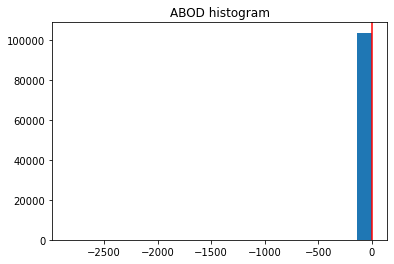

In [137]:
plt.hist(clf_ABOD.decision_scores_, bins=20)
plt.axvline(np.min(clf_ABOD.decision_scores_[np.where(outliers==1)]), c='r')

plt.title("ABOD histogram")
plt.show()

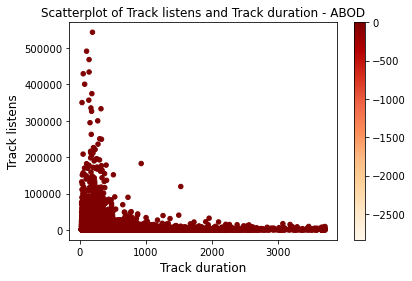

In [138]:
plt.scatter(df['track_duration'], df['track_listens'], s=20, c = clf_ABOD.decision_scores_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_listens'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track listens and Track duration - ABOD")

plt.colorbar()
plt.show()

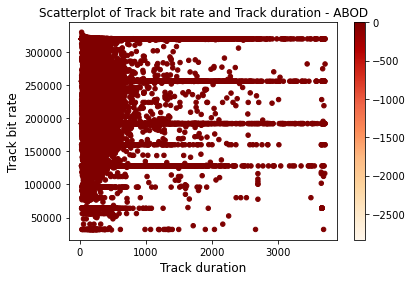

In [139]:
plt.scatter(df['track_duration'], df['track_bit_rate'], s=20, c = clf_ABOD.decision_scores_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - ABOD")
plt.colorbar()
plt.show()

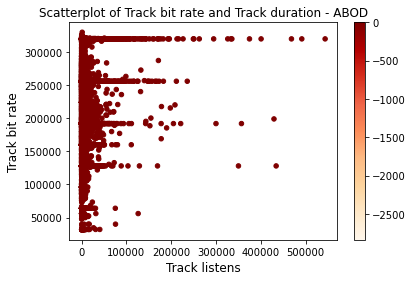

In [140]:
plt.scatter(df['track_listens'], df['track_bit_rate'], s=20, c = clf_ABOD.decision_scores_, cmap='OrRd')

plt.xlabel('track_listens'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - ABOD")
plt.colorbar()
plt.show()

<h2>ABOD n_neighbors = 10</h2>

In [141]:
clf_ABOD_2 = ABOD(n_neighbors=10)
clf_ABOD_2.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=10)

**Decision_scores_**

**The outlier scores of the training data**. The higher, the more abnormal. Outliers tend to have higher scores. This value is available once the detector is fitted.

In [142]:
clf_ABOD_2.decision_scores_

array([-4.78321238e-06, -8.41884311e-06, -6.85910681e-06, ...,
       -2.59377745e-05, -2.14810189e-04, -2.07792180e-05])

In [143]:
min(clf_ABOD_2.decision_scores_)

-689.9923055629802

In [144]:
max(clf_ABOD_2.decision_scores_)

-5.9452249197454e-22

In [145]:
outliers2 = clf_ABOD_2.predict(X)
np.unique(outliers2, return_counts=True)

(array([0, 1]), array([93629, 10079]))

In [146]:
np.where(outliers2==1)

(array([     3,     21,     22, ..., 103598, 103601, 103638]),)

In [147]:
outlier_indexes_abod2 = np.where(outliers2==1)[0]
outlier_indexes_abod2

array([     3,     21,     22, ..., 103598, 103601, 103638])

In [148]:
len(outlier_indexes_abod2)

10079

In [149]:
outlier_scores_abod2 = clf_ABOD_2.decision_scores_[outlier_indexes_abod2]

In [150]:
len(outlier_scores_abod2)

10079

In [151]:
np.max(outlier_scores_abod2)

-5.9452249197454e-22

In [152]:
np.min(outlier_scores_abod2)

-5.113730896256647e-10

In [153]:
outlier_abod_list2 = []

for i in range(0,len(outlier_scores_abod2)):
    outlier_abod_list2.append((outlier_indexes_abod2[i], outlier_scores_abod2[i]))
    
outlier_abod_list2

[(3, -1.6428486499247559e-12),
 (21, -1.90085789395736e-12),
 (22, -1.651184641801292e-12),
 (71, -1.0756916601564144e-10),
 (195, -2.7992174437571703e-11),
 (324, -3.33681246880433e-11),
 (325, -7.301501436089768e-12),
 (343, -2.8894183158454532e-11),
 (346, -1.8661167016295553e-11),
 (374, -1.3948637581844365e-12),
 (601, -6.206753376030903e-11),
 (603, -1.4986487244309774e-11),
 (604, -4.881151163499411e-11),
 (739, -5.1254844615403165e-11),
 (748, -9.619618125191367e-11),
 (826, -6.045046336329214e-11),
 (829, -6.66338662988743e-11),
 (830, -1.649600601993772e-11),
 (904, -1.0439048112590625e-10),
 (976, -3.996095965230207e-15),
 (984, -4.293308143691238e-11),
 (985, -2.5562395393796194e-11),
 (986, -2.714834415708834e-11),
 (1297, -4.449664354268362e-15),
 (1298, -3.0774379175952745e-12),
 (1299, -1.1859986911140173e-11),
 (1300, -7.779210361717342e-12),
 (1301, -2.8656100630533704e-11),
 (1310, -2.2217097211639245e-11),
 (1430, -9.211266124403622e-11),
 (1435, -8.261246798966963e

In [154]:
outlier_abod_list2 = sorted(outlier_abod_list2, key=outlier_score, reverse = True)

In [155]:
np.min(clf_ABOD_2.decision_scores_[np.where(outliers2==1)])

-5.113730896256647e-10

In [156]:
np.max(clf_ABOD_2.decision_scores_[np.where(outliers2==1)])

-5.9452249197454e-22

In [157]:
outlier_abod_list2[:10]

[(14443, -5.9452249197454e-22),
 (26842, -1.9036734794541094e-21),
 (49651, -2.4199549565657643e-21),
 (57355, -2.9771693660150218e-21),
 (40658, -5.2806520312857595e-21),
 (50011, -7.827836684876897e-21),
 (62388, -1.2195641862281118e-20),
 (17153, -1.9497538259162335e-20),
 (53166, -3.3693351292810087e-20),
 (43466, -3.412713640330523e-20)]

In [158]:
min([i[1] for i in outlier_abod_list2])

-5.113730896256647e-10

In [159]:
max([i[1] for i in outlier_abod_list2])

-5.9452249197454e-22

**Top 1% outliers**

In [160]:
top_outliers_ABOD2 = outlier_abod_list2[:top1perc]

In [161]:
indexes_list_ABOD2 = [i[0] for i in top_outliers_ABOD2] #retrieve index of outliers

In [162]:
df_ABOD_outliers2 = df.iloc[indexes_list_ABOD2]

In [163]:
df_ABOD_outliers2

,chroma_cens_02,chroma_cens_04,chroma_cens_06,chroma_cens_07,chroma_cens_09,chroma_cens_11,chroma_stft_05,chroma_stft_08,chroma_stft_10,chroma_stft_12,...,track_genre_top_Easy_Listening,track_genre_top_Instrumental,track_bit_rate,track_duration,track_listens,track_date_created_year,track_date_created_season,artist_favorites,album_favorites,album_type
track_id,,,,,,,,,,,,,,,,,,,,,
24425,0.582551,0.260160,0.302664,0.249650,0.218681,0.332331,0.265682,0.252215,0.359387,0.291845,...,0,0,128000,143,433992,3,4,92,12,0
42377,0.437262,0.388607,0.333384,0.412298,0.459646,0.248444,0.407478,0.482299,0.435781,0.454637,...,0,0,320000,194,543252,4,4,963,40,0
74724,0.297640,0.203927,0.225620,0.275323,0.132179,0.580131,0.338399,0.320418,0.306930,0.620235,...,0,0,128000,36,349903,5,4,26,11,0
86599,0.486504,0.368108,0.449803,0.353464,0.310841,0.208538,0.661808,0.612740,0.604628,0.599688,...,0,0,199007,54,429168,6,2,231,55,0
62460,0.250007,0.277574,0.238124,0.390601,0.471316,0.352164,0.439000,0.380467,0.473875,0.475469,...,0,0,192000,139,356588,5,1,788,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30424,0.212478,0.469032,0.565493,0.316175,0.193898,0.279368,0.723369,0.489398,0.378087,0.560486,...,0,0,253556,310,11017,3,1,45,10,0
60044,0.443341,0.238493,0.363699,0.471879,0.402490,0.290996,0.405679,0.435774,0.618316,0.386781,...,0,0,188408,1106,5627,5,4,33,7,0
37348,0.363809,0.350713,0.437716,0.375291,0.363841,0.379617,0.489140,0.305559,0.273953,0.413945,...,0,0,197616,1131,654,3,3,1,2,0


In [164]:
#retrieve track id of outliers
outliers_track_id_abod2 = list(df_ABOD_outliers2.index)
outliers_track_id_abod2[:10]

[24425, 42377, 74724, 86599, 62460, 75328, 95976, 28876, 81466, 66053]

In [165]:
len(outliers_track_id_abod2)

1037

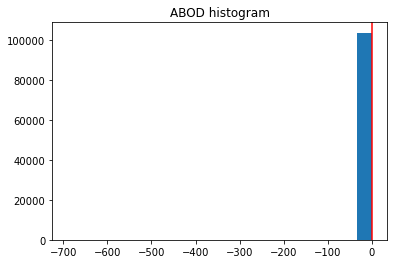

In [166]:
plt.hist(clf_ABOD_2.decision_scores_, bins=20)
plt.axvline(np.min(clf_ABOD_2.decision_scores_[np.where(outliers2==1)]), c='r')

plt.title("ABOD histogram")
plt.show()

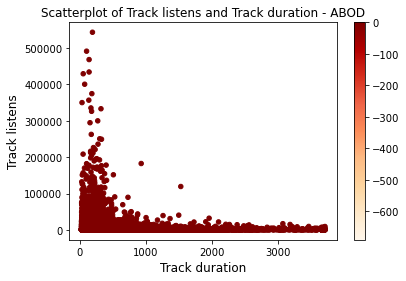

In [167]:
plt.scatter(df['track_duration'], df['track_listens'], s=20, c = clf_ABOD_2.decision_scores_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_listens'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track listens and Track duration - ABOD")

plt.colorbar()
plt.show()

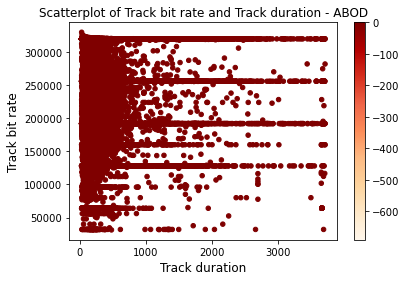

In [168]:
plt.scatter(df['track_duration'], df['track_bit_rate'], s=20, c = clf_ABOD_2.decision_scores_, cmap='OrRd')

plt.xlabel('track_duration'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - ABOD")
plt.colorbar()
plt.show()

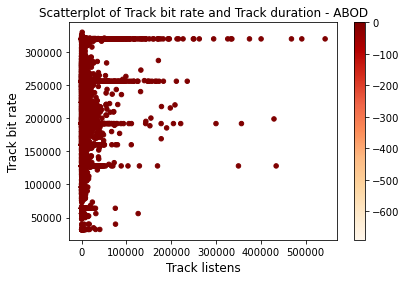

In [169]:
plt.scatter(df['track_listens'], df['track_bit_rate'], s=20, c = clf_ABOD_2.decision_scores_, cmap='OrRd')

plt.xlabel('track_listens'.capitalize().replace("_", " "), fontsize =12)
plt.ylabel('track_bit_rate'.capitalize().replace("_", " "), fontsize =12)

plt.title("Scatterplot of Track bit rate and Track duration - ABOD")
plt.colorbar()
plt.show()

<h1>Model based approaches</h1>

<h2>Isolation forest</h2>

In [63]:
from sklearn.ensemble import IsolationForest

In [64]:
clf_if = IsolationForest(random_state=0)
clf_if.fit(X_train_merged)

IsolationForest(random_state=0)

In [65]:
outliers_if = clf_if.predict(X_test)

In [66]:
np.unique(outliers_if, return_counts=True)

(array([-1,  1]), array([  142, 10732]))

In [84]:
outlier_indexes_if = np.where(outliers_if == -1)[0]

In [85]:
outlier_indexes_if

array([  246,   247,   288,   289,   294,   324,   396,   423,   432,
         592,   935,  1033,  1034,  1036,  1099,  1121,  1207,  1208,
        1209,  1210,  1211,  1213,  1214,  1215,  1217,  1395,  1396,
        1637,  1660,  1759,  1870,  1871,  1872,  1874,  1875,  1965,
        2296,  2353,  2519,  2601,  2783,  2860,  3057,  3071,  3465,
        3471,  3512,  3513,  3720,  3823,  3826,  3858,  3940,  4196,
        4305,  4561,  4563,  4649,  4680,  4704,  4773,  4851,  4890,
        5125,  5429,  5724,  5823,  5836,  5839,  6103,  6129,  6361,
        6371,  6479,  6525,  6599,  6605,  6769,  6805,  6807,  7652,
        7706,  7716,  7731,  7746,  7748,  8173,  8269,  8361,  8404,
        8545,  8608,  8697,  8754,  8768,  9026,  9083,  9107,  9108,
        9110,  9111,  9112,  9113,  9115,  9118,  9134,  9135,  9146,
        9197,  9272,  9319,  9480,  9546,  9550,  9620,  9698,  9748,
        9750,  9773,  9810,  9815,  9945,  9994, 10052, 10166, 10194,
       10203, 10207,

In [98]:
indexes_list_if = list(outlier_indexes_if)  #retrieve index of outliers

In [106]:
#df_if_outliers = df.iloc[indexes_list_if]

In [107]:
#df_if_outliers

In [108]:
#retrieve track id of outliers
#outliers_track_id_if = list(df_if_outliers.index)
#outliers_track_id_if[:10]

In [109]:
#len(outliers_track_id_if)